Importing libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import json
import re
from json.decoder import JSONDecodeError
import datetime

In [2]:
import import_ipynb
import ETL 

In [3]:
films = ETL.Films()
credits_final = films.get_credits_final()
movies_final = films.get_movies_final()

Starting ...


Falta graficas, borrar los que tienen valor de 0 en las votaciones y popularidad

In [4]:
movies_final.head(2)

,belongs_to_collection,budget,genres,id,original_language,overview,popularity,production_companies,production_countries,release_date,...,vote_count,belongs_to_collection_json,production_companies_json,release_date_clean,release_date_clean_format,retorno,month_movies,day_movies,year_movies,key_title
0,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",862,en,"Led by Woody, Andy's toys live happily in his ...",21.946943,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",30/10/1995,...,5415,"{'id': 10194, 'name': 'Toy Story Collection', ...","[{'name': 'Pixar Animation Studios', 'id': 3}]",30/10/1995,30/10/1995,12.451801,10,lunes,1995,toy story
1,,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",8844,en,When siblings Judy and Peter discover an encha...,17.015539,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",15/12/1995,...,2413,,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...",15/12/1995,15/12/1995,4.043035,12,viernes,1995,jumanji


In [5]:
movies_final.columns

Index(['belongs_to_collection', 'budget', 'genres', 'id', 'original_language',
       'overview', 'popularity', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'vote_average',
       'vote_count', 'belongs_to_collection_json', 'production_companies_json',
       'release_date_clean', 'release_date_clean_format', 'retorno',
       'month_movies', 'day_movies', 'year_movies', 'key_title'],
      dtype='object')

Revisando los outliers

In [6]:
movies_final['vote_count'].describe()

count    8427.000000
mean      201.836953
std       595.855008
min         0.000000
25%        12.000000
50%        35.000000
75%       126.000000
max      9678.000000
Name: vote_count, dtype: float64

In [7]:
movies_final['popularity'].describe()

count    8427.000000
mean        5.280933
std         4.984210
min         0.000000
25%         1.523100
50%         4.063135
75%         7.925636
max       140.950236
Name: popularity, dtype: float64

In [8]:
movies_final['spoken_languages'].describe()


count                                         8427
unique                                         572
top       [{'iso_639_1': 'en', 'name': 'English'}]
freq                                          6066
Name: spoken_languages, dtype: object

In [9]:
movies_final['vote_average'].mean()

np.float64(6.103548119140856)

Eliminando los outliers, para vote_averga, popularity, vote_count and popularity

In [110]:
movie_cleaned = movies_final

In [111]:
index = movie_cleaned [((movie_cleaned.vote_average == 0) | ( movie_cleaned.popularity == 0) | (movie_cleaned.vote_count == 0)
| (movie_cleaned.vote_count >= 100)  |  (movie_cleaned['popularity'] >= 10)  )].index

In [112]:
movie_cleaned = movie_cleaned.drop(index)

In [113]:
movie_cleaned['vote_count'].describe()

count    5649.000000
mean       26.844928
std        23.559010
min         1.000000
25%         9.000000
50%        19.000000
75%        38.000000
max        99.000000
Name: vote_count, dtype: float64

In [114]:
movie_cleaned['popularity'].describe()

count    5649.000000
mean        2.975546
std         2.383405
min         0.000220
25%         1.067539
50%         2.328347
75%         4.327218
max         9.987072
Name: popularity, dtype: float64

In [115]:
movie_cleaned['vote_average'].describe()

count    5649.000000
mean        6.021437
std         1.029045
min         0.500000
25%         5.500000
50%         6.100000
75%         6.700000
max        10.000000
Name: vote_average, dtype: float64

Limpiando NAN por empy string

In [116]:
movie_cleaned['overview'] = movies_final['overview'].fillna('')

Viendo gráficamente los datos

<Axes: xlabel='vote_count', ylabel='popularity'>

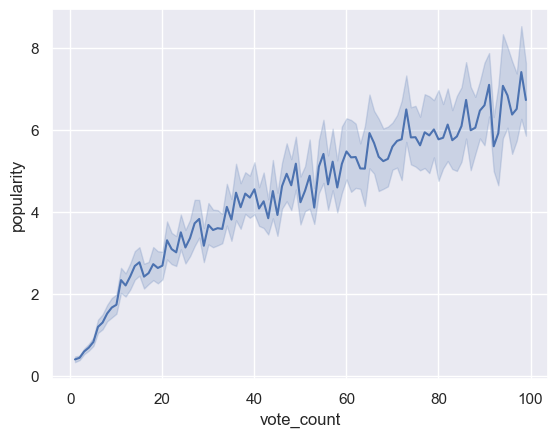

In [127]:
import seaborn as sns  
  

sns.lineplot(x="vote_count", y="popularity", data=movie_cleaned)

<Axes: xlabel='vote_average', ylabel='popularity'>

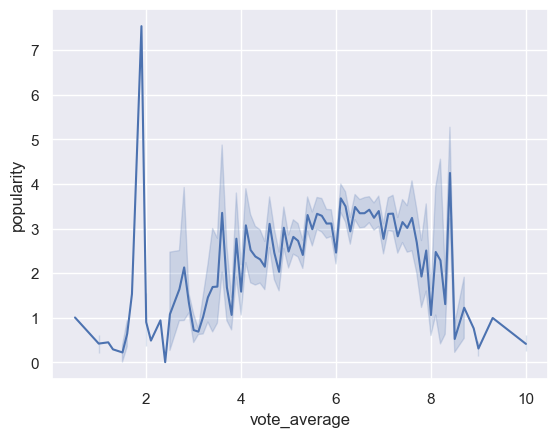

In [128]:
sns.lineplot(x="vote_average", y="popularity", data=movie_cleaned)

Eliminaremos los registros donde la popularidad es alta pero los votos fueron menos

In [130]:
index = movie_cleaned [  (movie_cleaned['popularity'] <= 2.5)  ].index

In [131]:
movie_cleaned = movie_cleaned.drop(index)

<Axes: xlabel='vote_average', ylabel='popularity'>

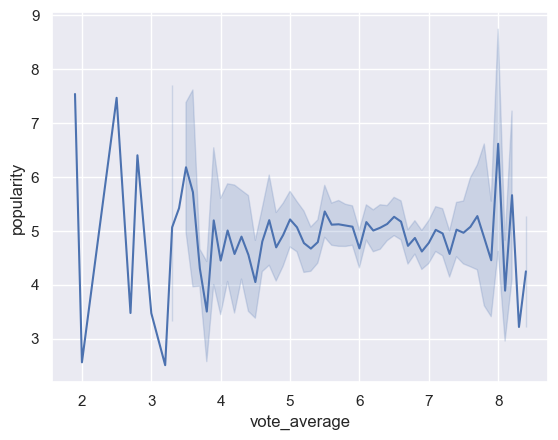

In [132]:
sns.lineplot(x="vote_average", y="popularity", data=movie_cleaned)

<Axes: xlabel='vote_average', ylabel='vote_count'>

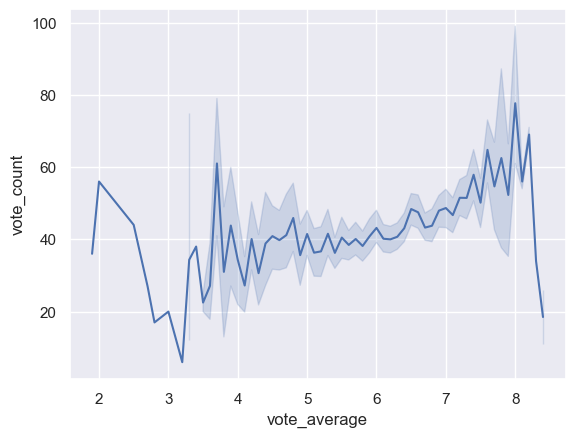

In [133]:
sns.lineplot(x="vote_average", y="vote_count", data=movie_cleaned)

Obtener las peliculas en base al titulo, ver las similitud

In [134]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(movie_cleaned['overview'])
tfidf_matrix.shape


(2681, 15758)

In [135]:
from sklearn.metrics.pairwise import linear_kernel

cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [137]:
indices = pd.Series(movie_cleaned.index, index=movie_cleaned['title']).drop_duplicates()

In [140]:
def get_recommendations_by_title(title, cosine_sim=cosine_sim):
    idx = indices[title]    
    sim_scores = list(enumerate(cosine_sim[idx]))    
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:6]
    movie_indices = [i[0] for i in sim_scores]
    return movie_cleaned['title'].iloc[movie_indices]


In [150]:
get_recommendations_by_title('Only You')

7668    While the City Sleeps
3325       Eyes of Laura Mars
3635                   Asylum
9078               Jack Frost
7623       Indestructible Man
Name: title, dtype: object

Recomendaciones donde interviene el producto entre popularidad y y votos

In [151]:
from sklearn.metrics.pairwise import cosine_similarity, cosine_distances

In [152]:
movies_recomendacion = movie_cleaned
def create_references(ref):
    string =  str(ref['popularity']*ref['vote_count'])
    
    return string


movies_recomendacion['reference'] = movies_recomendacion.apply(create_references, axis=1)
movies_recomendacion.head(1)

,belongs_to_collection,budget,genres,id,original_language,overview,popularity,production_companies,production_countries,release_date,...,belongs_to_collection_json,production_companies_json,release_date_clean,release_date_clean_format,retorno,month_movies,day_movies,year_movies,key_title,reference
3,,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",31357,en,"Cheated on, mistreated and stepped on, the wom...",3.859495,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",22/12/1995,...,,[{'name': 'Twentieth Century Fox Film Corporat...,22/12/1995,22/12/1995,5.09076,12,viernes,1995,waiting to exhale,131.22283


In [153]:
from sklearn.feature_extraction.text import CountVectorizer

count = CountVectorizer()
count_matrix = count.fit_transform(movies_recomendacion['reference'])

In [154]:
from sklearn.metrics.pairwise import cosine_similarity

cosine_sim2 = cosine_similarity(count_matrix, count_matrix)

In [155]:
movies_recomendacion = movies_recomendacion.reset_index()
indices = pd.Series(movies_recomendacion.index, index=movies_recomendacion['title'])

In [156]:
# Function that takes in movie title as input and outputs most similar movies
def get_recommendations_by_prod_ref(title, cosine_sim=cosine_sim):
    # Get the index of the movie that matches the title
    idx = indices[title]

    # Get the pairwsie similarity scores of all movies with that movie    
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar movies
    sim_scores = sim_scores[1:6]

    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores]

    # Return the top 10 most similar movies
    return movies_recomendacion['title'].iloc[movie_indices]

In [158]:
get_recommendations_by_prod_ref('Only You',cosine_sim2)

450     The Gods Must Be Crazy II
688                   Holiday Inn
1848                   King Ralph
1941                     Trespass
2467              Robinson Crusoe
Name: title, dtype: object

Recomendaciones por weighted_rating

In [159]:
q_movies = movie_cleaned

In [161]:
C = q_movies['vote_average'].mean()
m = q_movies['vote_count'].quantile(0.90)


In [162]:
# Function that computes the weighted rating of each movie
def weighted_rating(x, m=m, C=C):
    v = x['vote_count']
    R = x['vote_average']
    # Calculation based on the IMDB formula
    return (v/(v+m) * R) + (m/(m+v) * C)

In [163]:
q_movies['score'] = q_movies.apply(weighted_rating, axis=1)

In [164]:
#Sort movies based on score calculated above
q_movies = q_movies.sort_values('score', ascending=False)

#Print the top 15 movies
q_movies[['title', 'vote_count', 'vote_average', 'score']].head(5)



,title,vote_count,vote_average,score
8617,PlayTime,99,8.0,7.172551
8860,Anne of Green Gables,71,8.2,7.112760
1151,Paris is Burning,67,8.2,7.082973
8572,Crooks in Clover,96,7.8,7.048652
7819,A Matter of Life and Death,73,8.0,7.031014


In [165]:
index = q_movies.index
q_movies['index']= index

In [166]:
movieRatings = q_movies.pivot_table(index=['vote_count', 'vote_average'], columns='title',values='score', aggfunc='sum', fill_value=0)  
movieRatings.head()

title                    ...And God Created Woman   10  10 Rillington Place  \
vote_count vote_average                                                       
3          5.2                                0.0  0.0                  0.0   
           6.8                                0.0  0.0                  0.0   
4          3.9                                0.0  0.0                  0.0   
           4.3                                0.0  0.0                  0.0   
           5.5                                0.0  0.0                  0.0   

title                    10 to Midnight  101 Reykjavik  \
vote_count vote_average                                  
3          5.2                      0.0            0.0   
           6.8                      0.0            0.0   
4          3.9                      0.0            0.0   
           4.3                      0.0            0.0   
           5.5                      0.0            0.0   

title                    11'09''01 - September 11  13 Ghosts  \
vote_count vote_average                                        
3          5.2                                0.0        0.0   
           6.8                                0.0        0.0   
4          3.9                                0.0        0.0   
           4.3                                0.0        0.0   
           5.5                                0.0        0.0   

title                    2 Days in the Valley  20 Million Miles to Earth  \
vote_count vote_average                                                    
3          5.2                            0.0                        0.0   
           6.8                            0.0                        0.0   
4          3.9                            0.0                        0.0   
           4.3                            0.0                        0.0   
           5.5                            0.0                        0.0   

title                    200 Cigarettes  ...  Young and Innocent  Youngblood  \
vote_count vote_average                  ...                                   
3          5.2                      0.0  ...                 0.0         0.0   
           6.8                      0.0  ...                 0.0         0.0   
4          3.9                      0.0  ...                 0.0         0.0   
           4.3                      0.0  ...                 0.0         0.0   
           5.5                      0.0  ...                 0.0         0.0   

title                    Yours, Mine and Ours  Yu-Gi-Oh! The Movie  \
vote_count vote_average                                              
3          5.2                            0.0                  0.0   
           6.8                            0.0                  0.0   
4          3.9                            0.0                  0.0   
           4.3                            0.0                  0.0   
           5.5                            0.0                  0.0   

title                    Zabriskie Point  Zapped!  Zero Effect  Zero Hour!  \
vote_count vote_average                                                      
3          5.2                       0.0      0.0          0.0         0.0   
           6.8                       0.0      0.0          0.0         0.0   
4          3.9                       0.0      0.0          0.0         0.0   
           4.3                       0.0      0.0          0.0         0.0   
           5.5                       0.0      0.0          0.0         0.0   

title                    Zorba the Greek  Zorro, The Gay Blade  
vote_count vote_average                                         
3          5.2                       0.0                   0.0  
           6.8                       0.0                   0.0  
4          3.9                       0.0                   0.0  
           4.3                       0.0                   0.0  
           5.5                       0.0                   0.0  

[5

In [167]:
movieRatings = movieRatings.applymap(lambda x: 1 if x > 0 else 0)

C:\Users\DELIA MONTOYA\AppData\Local\Temp\ipykernel_15652\3000525354.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  movieRatings = movieRatings.applymap(lambda x: 1 if x > 0 else 0)


In [168]:
movieRatings

title                    ...And God Created Woman  10  10 Rillington Place  \
vote_count vote_average                                                      
3          5.2                                  0   0                    0   
           6.8                                  0   0                    0   
4          3.9                                  0   0                    0   
           4.3                                  0   0                    0   
           5.5                                  0   0                    0   
...                                           ...  ..                  ...   
99         6.8                                  0   0                    0   
           6.9                                  0   0                    0   
           7.0                                  0   0                    0   
           7.4                                  0   0                    0   
           8.0                                  0   0                    0   

title                    10 to Midnight  101 Reykjavik  \
vote_count vote_average                                  
3          5.2                        0              0   
           6.8                        0              0   
4          3.9                        0              0   
           4.3                        0              0   
           5.5                        0              0   
...                                 ...            ...   
99         6.8                        0              0   
           6.9                        0              0   
           7.0                        0              0   
           7.4                        0              0   
           8.0                        0              0   

title                    11'09''01 - September 11  13 Ghosts  \
vote_count vote_average                                        
3          5.2                                  0          0   
           6.8                                  0          0   
4          3.9                                  0          0   
           4.3                                  0          0   
           5.5                                  0          0   
...                                           ...        ...   
99         6.8                                  0          0   
           6.9                                  0          0   
           7.0                                  0          0   
           7.4                                  0          0   
           8.0                                  0          0   

title                    2 Days in the Valley  20 Million Miles to Earth  \
vote_count vote_average                                                    
3          5.2                              0                          0   
           6.8                              0                          0   
4          3.9                              0                          0   
           4.3                              0                          0   
           5.5                              0                          0   
...                                       ...                        ...   
99         6.8                              0                          0   
           6.9                              0                          0   
           7.0                              0                          0   
           7.4                              0                          0   
           8.0                              0                          0   

title                    200 Cigarettes  ...  Young and Innocent  Youngblood  \
vote_count vote_average                  ...                                   
3          5.2                        0  ...                   0           0   
           6.8                        0  ...                   0           0   
4          3.9                        0  ...                   0           0   
        

In [169]:
from sklearn.metrics.pairwise import cosine_similarity


In [170]:
index_movieRatings = pd.DataFrame(
    cosine_similarity(movieRatings)
)

In [171]:
index_movieRatings

,0,1,2,3,4,5,6,7,8,9,...,1639,1640,1641,1642,1643,1644,1645,1646,1647,1648
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1644,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1645,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1646,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1647,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [172]:
index_movieRatings.columns = movieRatings.index
index_movieRatings['index'] = movieRatings.index
index_movieRatings = index_movieRatings.set_index('index')

In [173]:
index_movieRatings['index'] = movieRatings.index
index_movieRatings = index_movieRatings.set_index('index')

In [175]:
toyStoryRatings = movieRatings['Only You']
#print(toyStoryRatings)

# Correlamos el resto de peliculas (columnas) con la seleccionada (toy story)  
similarMovies = movieRatings.corrwith(toyStoryRatings)  
#print(similarMovies)
similarMovies = similarMovies.dropna()  
#print(similarMovies)
df = pd.DataFrame(similarMovies)

# Las ordenamos por el valor de score que hemos generado, de forma descendente  
similarMovies.sort_values(ascending=False)  

title
Only You                1.000000
She Hate Me            -0.000607
Bloody Mama            -0.000607
The Great White Hype   -0.000607
The Indian Runner      -0.000607
                          ...   
Carrie                 -0.000858
The In-Laws            -0.000858
Little Women           -0.000858
A Kiss Before Dying    -0.000858
Cat People             -0.000858
Length: 2664, dtype: float64

Recomendación basada en créditos, géneros y palabras clave

In [177]:
metadata = movie_cleaned
metadata = metadata.drop(['budget','production_companies','production_countries','release_date_clean','revenue','runtime','status', 'tagline','release_date_clean', 'release_date_clean_format', 'retorno',
       'month_movies', 'day_movies', 'year_movies','popularity','release_date','vote_average','vote_count','belongs_to_collection_json','production_companies_json','title','reference','score','belongs_to_collection'
       ,'original_language'], axis=1)

In [178]:
def get_list(x):    
    if isinstance(x, list): 
        names = [i['name'] for i in x]
        #Check if more than 3 elements exist. If yes, return only first three. If no, return entire list        
        if len(names) > 3:
            
            names = names[:3]
        return names
    else:
        x=x.replace("'","\"")
        data = json.loads(x)
        names = [i['name'] for i in data]
        return names
    #Return empty list in case of missing/malformed data
    return []

In [179]:
features = ['spoken_languages', 'genres']
for feature in features:
    metadata[feature] = metadata[feature].apply(get_list)

In [180]:
def create_mix(x):
    spoken_languages = ' '.join(x['spoken_languages'])
    genres = ' '.join(x['genres'])
    return spoken_languages + ' '+genres+' '+x['overview'] + ' '

In [181]:
# Create a new soup feature
metadata['mix'] = metadata.apply(create_mix, axis=1)

In [182]:
# Import CountVectorizer and create the count matrix
from sklearn.feature_extraction.text import CountVectorizer

count = CountVectorizer(stop_words='english')
count_matrix = count.fit_transform(metadata['mix'])

In [183]:
# Compute the Cosine Similarity matrix based on the count_matrix
from sklearn.metrics.pairwise import cosine_similarity

cosine_sim2 = cosine_similarity(count_matrix, count_matrix)

In [184]:
# Reset index of your main DataFrame and construct reverse mapping as before
metadata = metadata.reset_index()
indices = pd.Series(metadata.index, index=metadata['key_title'])

In [187]:
metadata.head()

,index,genres,id,overview,spoken_languages,key_title,mix
0,3,"[Comedy, Drama, Romance]",31357,"Cheated on, mistreated and stepped on, the wom...",[English],waiting to exhale,"English Comedy Drama Romance Cheated on, mistr..."
1,7,"[Action, Adventure, Drama]",45325,"A mischievous young boy, Tom Sawyer, witnesses...","[English, Deutsch]",tom and huck,English Deutsch Action Adventure Drama A misch...
2,13,"[History, Drama]",10858,An all-star cast powers this epic look at Amer...,[English],nixon,English History Drama An all-star cast powers ...
3,26,"[Comedy, Drama, Family]",9263,Waxing nostalgic about the bittersweet passage...,[English],now and then,English Comedy Drama Family Waxing nostalgic a...
4,40,"[Drama, War]",31174,Shakespeare's Play transplanted into a 1930s s...,[English],richard iii,English Drama War Shakespeare's Play transplan...


In [189]:
# Function that takes in movie title as input and outputs most similar movies
def get_recommendations(title, cosine_sim=cosine_sim):
    # Get the index of the movie that matches the title
    idx = indices[title]

    # Get the pairwsie similarity scores of all movies with that movie    
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar movies
    sim_scores = sim_scores[1:6]

    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores]

    # Return the top 10 most similar movies
    return movies_recomendacion['title'].iloc[movie_indices]

In [191]:
get_recommendations('only you', cosine_sim2)

809     Bell, Book and Candle
187         Til There Was You
36                    Jeffrey
1867     What's New Pussycat?
855            Prizzi's Honor
Name: title, dtype: object